In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# import datasets
!wget --no-check-certificate \
  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
  -O /tmp/rps.zip

!wget --no-check-certificate \
  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
  -O /tmp/rps-test-set.zip

--2023-01-02 01:59:40--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M   185MB/s    in 1.0s    

2023-01-02 01:59:41 (185 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2023-01-02 01:59:41--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/t

In [ ]:
# extract zip file
import zipfile
import os

local_zip = '/tmp/rps.zip'
zip_extract = zipfile.ZipFile(local_zip, 'r')
zip_extract.extractall('/tmp/')
zip_extract.close()

local_zip = '/tmp/rps-test-set.zip'
zip_extract = zipfile.ZipFile(local_zip, 'r')
zip_extract.extractall('/tmp/')
zip_extract.close()

In [ ]:
# image augmentation
train_datagen = ImageDataGenerator(rescale = 1./255)
train_datagen

In [ ]:
TRAINING_DIR = '/tmp/rps/'

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (150, 150),
    class_mode = 'categorical',
)

VALIDATION_DIR = '/tmp/rps-test-set'

validation_generator = train_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size = (150, 150),
    class_mode = 'categorical',
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(3, activation = 'softmax')
])

In [ ]:
# count loss function and optimizer
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']               
)

In [ ]:
# train data
history = model.fit(
    train_generator,
    steps_per_epoch = 10,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 5,
    verbose = 1,
)

Epoch 1/20
 2/10 [=====>........................] - ETA: 19s - loss: 4.6536e-05 - accuracy: 1.0000

KeyboardInterrupt: ignored

In [10]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img
#from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
  # predict images
  path = fn
  img_source = tf.keras.utils.load_img(path, target_size = (150, 150))
  imgplot = plt.imshow(img_source)
  x = tf.keras.utils.img_to_array(img_source)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  if classes[0, 0] == 1:
    print('Pedra')
  elif classes[0, 1] == 1:
    print('Papel')
  elif classes[0, 2] == 1:
    print('Tesoura')

Saving paper.png to paper.png


NameError: ignored

None


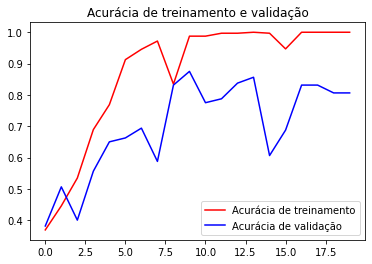

<Figure size 432x288 with 0 Axes>

In [ ]:
# Verificando a eficácia do modelo
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Acurácia de treinamento')
plt.plot(epochs, val_acc, 'b', label='Acurácia de validação')
plt.title('Acurácia de treinamento e validação')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
# Salvando o modelo
model.save('rps.h5')

In [2]:
from keras.models import load_model
model = load_model('rps.h5')
model.summary()

ModuleNotFoundError: No module named 'keras'

In [1]:
from keras.models import load_model
model = load_model('rps.h5')
model.summary()

import pickle
import sqlite3

# Serializando o modelo em um arquivo pickle
with open('model.pkl', 'wb') as f:
  pickle.dump(model, f)

# Conectando com o banco de dados
conn = sqlite3.connect('database.db')

# Inserindo uma linha na tabela com o modelo de arquivo BLOB
cursor = conn.cursor()
query = 'INSERT INTO models (model) VALUES (?)'
with open('model.pkl', 'rb') as f:
  model_blob = f.read()
cursor.execute(query, (memoryview(model_blob),))
conn.commit()

# Recuperando o modelo da tabela como BLOB
id = 1
cursor.execute('SELECT model FROM models WHERE id = ?', (id,))
model_blob = cursor.fetchone()[0]

# Salvando e desserializando  o modelo 
with open('model_from_db.pkl', 'wb') as f:
  f.write(model_blob)

with open('model_from_db.pkl', 'rb') as f:
  model_from_db = pickle.load(f)

# Encerrando a conexão
#conn.close()


ModuleNotFoundError: No module named 'keras'